In [3]:
# Importing necessary packages
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import contextily as cx

In [4]:
#pip install --upgrade openpyxl

In [5]:
#Reading in all US DOT data
rail = gpd.read_file("C:/Users/shiva/Downloads/North_American_Rail_Network_Lines.geojson")

In [30]:
# Basic info
print("Shape")
print(rail.shape)
print("\nColumns")
print(rail.columns)
print("\nHead")
print(rail.head())

Shape
(302993, 35)

Columns
Index(['objectid', 'fraarcid', 'frfranode', 'tofranode', 'stfips', 'cntyfips',
       'stcntyfips', 'stateab', 'country', 'fradistrct', 'rrowner1',
       'rrowner2', 'rrowner3', 'trkrghts1', 'trkrghts2', 'trkrghts3',
       'trkrghts4', 'trkrghts5', 'trkrghts6', 'trkrghts7', 'trkrghts8',
       'trkrghts9', 'division', 'subdiv', 'branch', 'yardname', 'passngr',
       'stracnet', 'tracks', 'net', 'miles', 'km', 'timezone', 'shape_Length',
       'geometry'],
      dtype='object')

Head
   objectid  fraarcid  frfranode  tofranode stfips cntyfips stcntyfips  \
0         1    300000     348741     348746     38      015      38015   
1         2    300001     338567     338686     30      087      30087   
2         3    300002     330112     330117     16      031      16031   
3         4    300003     330113     330116     16      031      16031   
4         7    300006     312341     312373     41      035      41035   

  stateab country  fradistrct  ... 

In [31]:
#importing NOAA climate data
climate = pd.read_excel("C:/Users/shiva/OneDrive/2024-01-Spring/Capstone/NOAA data/StormEvents_details_2022-2018 Damage Analysis.xlsx")
print(climate.head())

   BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           202202         20        2118         202202       20      2218   
1           202202         21         800         202202       22      1000   
2           202202         22         200         202202       22       900   
3           202202         18        1609         202202       18      1609   
4           202202          2           0         202202        3         0   

   EPISODE_ID  EVENT_ID           STATE  STATE_FIPS  ...  BEGIN_RANGE  \
0      165464    999902          NEVADA          32  ...          NaN   
1      165465    999903          NEVADA          32  ...          NaN   
2      165465    999904          NEVADA          32  ...          NaN   
3      165611   1001181  ATLANTIC SOUTH          87  ...          7.0   
4      165668   1001527  AMERICAN SAMOA          97  ...          5.0   

  BEGIN_AZIMUTH BEGIN_LOCATION END_RANGE  END_AZIMUTH END_LOCATION BEGIN_LAT  \
0     

In [32]:
# Full dictionary mapping all U.S. state names to their abbreviations
state_mapping = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA', 'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE',
    'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI', 'IDAHO': 'ID',
    'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS',
    'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK',
    'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT',
    'VERMONT': 'VT', 'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI', 'WYOMING': 'WY'
}

# List of states to remove from the plot
states_to_remove = ['ALASKA', 'AMERICAN SAMOA', 'ATLANTIC NORTH', 'ATLANTIC SOUTH', 
                    'E PACIFIC', 'GUAM', 'GULF OF MEXICO', 'HAWAII',
                    'HAWAII WATERS', 'LAKE ERIE', 'LAKE HURON', 'LAKE MICHIGAN', 
                    'LAKE ONTARIO', 'LAKE ST CLAIR', 'LAKE SUPERIOR', 'PUERTO RICO', 
                    'ST LAWRENCE R', 'VIRGIN ISLANDS'] 

# Create a copy of the filtered DataFrame
filtered_climate_data = climate[~climate['STATE'].isin(states_to_remove)].copy()

# Apply the mapping to create the 'state_ab' column 
filtered_climate_data.loc[:, 'state_ab'] = filtered_climate_data['STATE'].map(state_mapping)

#number of unique states in the filtered climate data
print("Unique states in climate data:", filtered_climate_data['state_ab'].nunique())



Unique states in climate data: 48


In [33]:
#limit the data to the first 50,000 rows
climate_reduced = filtered_climate_data[['state_ab', 'EVENT_ID']].head(50000) 
rail_reduced = rail[['stateab', 'objectid', 'miles']].head(50000) 

# Merge the reduced datasets
merged_data = pd.merge(climate_reduced, rail_reduced, left_on='state_ab', right_on='stateab', how='inner')


In [34]:
#sampling and chunk processing
import pandas as pd

# Sample a subset of each DataFrame to reduce the memory footprint
sample_fraction = 0.1  
climate_sampled = climate_reduced.sample(frac=sample_fraction, random_state=1)
rail_sampled = rail_reduced.sample(frac=sample_fraction, random_state=1)

# chunk size 
chunk_size = 5000 
num_chunks = len(rail_sampled) // chunk_size + 1

list_of_merged_chunks = []
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size
    rail_chunk = rail_sampled[start:end]
    merged_chunk = pd.merge(climate_sampled, rail_chunk, left_on='state_ab', right_on='stateab', how='inner')
    list_of_merged_chunks.append(merged_chunk)

# Concatenate chunks into a single DataFrame
final_merged_data = pd.concat(list_of_merged_chunks, ignore_index=True)

# check the size of the final merged data
print("Merged data size:", final_merged_data.shape)


Merged data size: (610659, 5)


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Apply state mapping and ensure 'state_ab' column is available
climate['state_ab'] = climate['STATE'].map(state_mapping)

# Convert year-month columns to string
climate['BEGIN_YEARMONTH'] = climate['BEGIN_YEARMONTH'].astype(str)
climate['END_YEARMONTH'] = climate['END_YEARMONTH'].astype(str)

# Filter for events between 2018 and 2022
years = ['2018', '2019', '2020', '2021', '2022']
climate_filtered = climate[
    (climate['BEGIN_YEARMONTH'].str[:4].isin(years)) |
    (climate['END_YEARMONTH'].str[:4].isin(years))
]

# Count unique climate events per state
climate_counts = climate_filtered.groupby('state_ab')['EVENT_ID'].nunique().reset_index()
climate_counts.columns = ['state_ab', 'climate_event_count']

# Prepare the rail data 
rail_counts = rail.groupby('stateab').size().reset_index(name='rail_line_count')

# Merge the counts into a single DataFrame
density_data = pd.merge(climate_counts, rail_counts, left_on='state_ab', right_on='stateab', how='outer').fillna(0)
density_data['state_ab'] = density_data['state_ab'].fillna(density_data['stateab'])
density_data.drop(columns=['stateab'], inplace=True)  # Clean up after merge

# Ensure no missing values in counts
density_data.fillna(0, inplace=True)

# Print the density data
print(density_data)

density_data = density_data[density_data['climate_event_count'] > 0]


   state_ab  climate_event_count  rail_line_count
0         0                  0.0             9519
1         0                  0.0               20
2        AK               1131.0              638
3        AL               5714.0             5099
4        AR               6175.0             3393
..      ...                  ...              ...
88       WV               4998.0             2650
89       WY               5331.0             2330
90        0                  0.0               66
91        0                  0.0               12
92        0                  0.0               42

[93 rows x 3 columns]


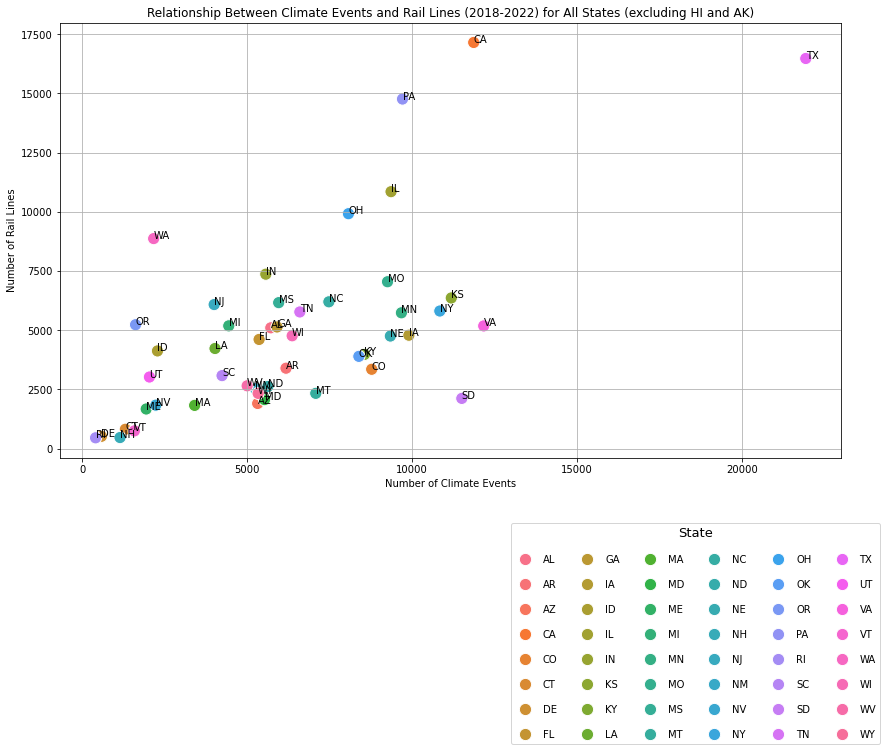

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out Hawaii (HI) and Alaska (AK) and where climate event count is 0
density_data = density_data[(density_data['state_ab'] != 'HI') & (density_data['state_ab'] != 'AK')]
density_data = density_data[density_data['climate_event_count'] > 0]

# Creating the scatterplot for the states
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(data=density_data, x='climate_event_count', y='rail_line_count', hue='state_ab', s=150)  

# Title and labels
plt.title('Relationship Between Climate Events and Rail Lines (2018-2022) for All States (excluding HI and AK)')
plt.xlabel('Number of Climate Events')
plt.ylabel('Number of Rail Lines')
plt.grid(True)  

# Loop through the data points to add labels with an increased font size
for line in range(0, density_data.shape[0]):
    plt.text(density_data.climate_event_count.iloc[line], density_data.rail_line_count.iloc[line], 
             density_data.state_ab.iloc[line], horizontalalignment='left', size='medium', color='black') 

# Adjust legend orientation to be horizontal
plt.legend(title='State', title_fontsize='13', labelspacing=1.5, bbox_to_anchor=(1.05, -0.15), loc='upper right', ncol=6, borderaxespad=0.)


plt.show()
